# Roland's Working Notebook

## Description

Here's where I'd outline the goals of this specific notebook, and how they fit into the larger project goals

In [62]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
from scipy.stats import f_oneway
from scipy.stats import ttest_1samp

conn = sqlite3.connect('..\..\data\im.db')


## Correlating Genre with Net Profit
### Step 1 - Gathering the Data
The two columns of interest to correlate are Genres, and World Wide Gross Profit. The Genres information can be found in the `im.db` database, in the `movie_basics` table, under the column named `genres`. The World Wide Gross Profit can be found in the `tn.movie_budgets.csv` file under the column `worldwide_gross`.

In [63]:
genre_data = pd.read_sql("""
SELECT mb.genres, AVG(mob.worldwide_gross - mob.production_budget) as mean_net_profit
FROM movie_basics mb, movie_budgets mob
WHERE mb.primary_title = mob.movie
GROUP BY mb.genres
ORDER BY mean_net_profit DESC;
""", conn)
genre_data

,genres,mean_net_profit
0,"Fantasy,Romance",1.122470e+09
1,"Adventure,Drama,Sport",1.122470e+09
2,"Family,Fantasy,Musical",8.438154e+08
3,"Adventure,Fantasy",4.695440e+08
4,"Action,Adventure,Sci-Fi",4.385199e+08
...,...,...
341,"Drama,History,Sport",-2.983117e+07
342,"Action,Fantasy,Western",-3.348568e+07
343,"Drama,Fantasy,Thriller",-3.992088e+07
344,"Action,Family,Fantasy",-6.953398e+07


### Step 5 - Creating Figures and Graphs
Finally we must create graphs that can show our business partners which genres would be good to focus on. The average net_profit for these 10 genres in our graph are the highest of any genres in the database

<AxesSubplot:xlabel='genres'>

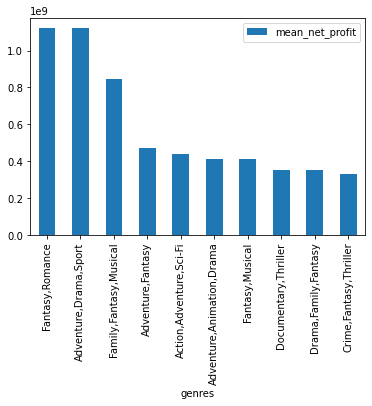

In [64]:
genre_data.head(10).plot.bar(x='genres',y='mean_net_profit')

## Correlating Season with Net Profit
### Step 1
As from before, our first step is always to take the data from whichever database it is housed in and make sure that we get all the columns we need

In [65]:
season_agg = pd.read_sql("""
SELECT SUBSTR(release_date, 0, 4) as month, AVG(worldwide_gross - production_budget) as mean_net_profit
FROM movie_budgets
GROUP BY month
ORDER BY mean_net_profit DESC
""", conn)
season_agg

,month,mean_net_profit
0,May,1.151328e+08
1,Jun,9.942391e+07
2,Jul,9.841746e+07
3,Nov,9.314157e+07
4,Dec,6.844157e+07
5,Mar,4.985129e+07
6,Feb,4.349811e+07
7,Apr,3.611743e+07
8,Aug,3.542232e+07
9,Oct,2.907190e+07


### Step 2 - Cleaning up the data
For comparing Season with Net Profit, both items are in the same file so it becomes much easier to load and manipulate the data. For this comparison we want to see if the season has an impact on the net profit that a movie makes. In order to accomplish this we must map the release date to one of the four seasons and then move on to aggregation.

<AxesSubplot:xlabel='month'>

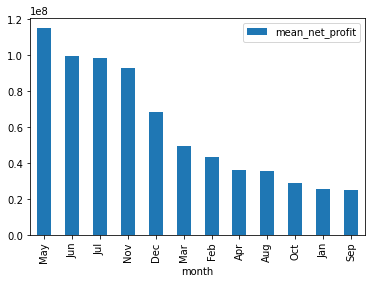

In [66]:
season_agg.plot.bar(x='month', y='mean_net_profit')

In [67]:
season = pd.read_sql("""
SELECT SUBSTR(release_date, 0, 4) as month, (worldwide_gross - production_budget) as net_profit
FROM movie_budgets
ORDER BY net_profit DESC
""", conn)
season

,month,net_profit
0,Dec,2351345279
1,Dec,2008208395
2,Apr,1748134200
3,Dec,1747311220
4,Jun,1433854864
...,...,...
5777,Apr,-94635231
5778,Jun,-106900000
5779,Mar,-110450242
5780,Dec,-150000000


In [68]:
jan = season[season.month == 'Jan'].net_profit
feb = season[season.month == 'Feb'].net_profit
mar = season[season.month == 'Mar'].net_profit
apr = season[season.month == 'Apr'].net_profit
may = season[season.month == 'May'].net_profit
jun = season[season.month == 'Jun'].net_profit
jul = season[season.month == 'Jul'].net_profit
aug = season[season.month == 'Aug'].net_profit
sep = season[season.month == 'Sep'].net_profit
oct = season[season.month == 'Oct'].net_profit
nov = season[season.month == 'Nov'].net_profit
dec = season[season.month == 'Dec'].net_profit

f_oneway(jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec)

F_onewayResult(statistic=24.453383228456946, pvalue=4.995036106067499e-50)

In [70]:
sample = pd.read_sql("""
SELECT SUBSTR(release_date, 0, 4) as month, AVG(worldwide_gross - production_budget) as mean_net_profit
FROM movie_budgets
GROUP BY month
ORDER BY mean_net_profit DESC
LIMIT 3;
""", conn)
t_test = ttest_1samp(sample.mean_net_profit, season_agg.mean_net_profit.mean())
t_test

Ttest_1sampResult(statistic=8.20387442063385, pvalue=0.014534905865154104)

In [ ]:
director = pd.read_sql("""
SELECT pe.primary_name as director, AVG(mob.worldwide_gross - mob.production_budget) as mean_net_profit, COUNT(pe.primary_name) as num_movies
FROM movie_basics mb, principals pr, persons pe, movie_budgets mob
WHERE   mb.movie_id = pr.movie_id 
        AND pr.person_id = pe.person_id
        AND mb.primary_title = mob.movie
        AND pr.category = 'director'
GROUP BY pe.primary_name
HAVING num_movies > 5
ORDER BY mean_net_profit DESC
LIMIT 10
;
""", conn)
director

,director,mean_net_profit,num_movies
0,Tim Burton,1.908611e+08,6
1,Ridley Scott,1.769673e+08,7
2,Steven Spielberg,1.647550e+08,8
3,Jon M. Chu,1.502429e+08,6
4,Clint Eastwood,1.379160e+08,6
5,Jaume Collet-Serra,7.547862e+07,6
6,Denis Villeneuve,5.732786e+07,6
7,Tim Story,4.845786e+07,9
8,Steven Soderbergh,4.558173e+07,7
9,David Gordon Green,4.236483e+07,8


<AxesSubplot:xlabel='director'>

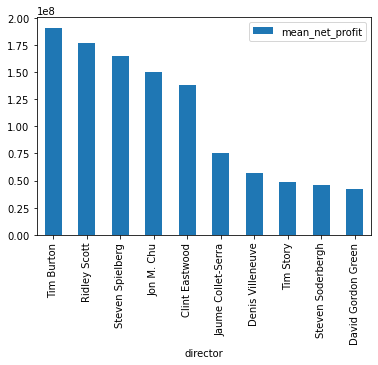

In [ ]:
director.plot.bar(x='director', y='mean_net_profit')

In [ ]:
writer = pd.read_sql("""
SELECT pe.primary_name as writer, AVG(mob.worldwide_gross - mob.production_budget) as mean_net_profit, COUNT(pe.primary_name) as num_movies
FROM movie_basics mb, principals pr, persons pe, movie_budgets mob
WHERE   mb.movie_id = pr.movie_id 
        AND pr.person_id = pe.person_id
        AND mb.primary_title = mob.movie
        AND pr.category = 'writer'
GROUP BY pe.primary_name
HAVING num_movies > 5
ORDER BY mean_net_profit DESC
LIMIT 10
;
""", conn)
writer

,writer,mean_net_profit,num_movies
0,Jack Kirby,6.235416e+08,13
1,Stephen McFeely,6.037486e+08,7
2,Christopher Markus,6.037486e+08,7
3,Stan Lee,5.967671e+08,16
4,Linda Woolverton,5.860717e+08,7
5,Rick Jaffa,4.822119e+08,6
6,Amanda Silver,4.822119e+08,6
7,Jeff Pinkner,3.706335e+08,6
8,Jonathan Aibel,2.590552e+08,6
9,Glenn Berger,2.590552e+08,6


<AxesSubplot:xlabel='writer'>

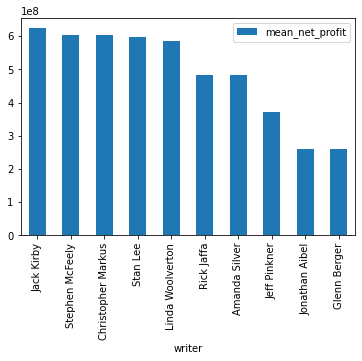

In [ ]:
writer.plot.bar(x='writer', y='mean_net_profit')

In [ ]:
pb = pd.read_sql("""
SELECT  movie, 
        CAST(worldwide_gross as FLOAT) / CAST(production_budget as FLOAT) as ratio, 
        production_budget, 
        worldwide_gross,
        worldwide_gross - production_budget as net_profit
FROM movie_budgets mob
WHERE   ratio < 100
        AND production_budget > 30000000
ORDER BY ratio DESC, production_budget DESC;
""", conn)
pb

,movie,ratio,production_budget,worldwide_gross,net_profit
0,It,19.927371,35000000,697457969,662457969
1,Star Wars Ep. VI: Return of the Jedi,17.621695,32500000,572705079,540205079
2,The Sixth Sense,16.820157,40000000,672806292,632806292
3,Jurassic Park,16.489089,63000000,1038812584,975812584
4,Bohemian Rhapsody,16.272461,55000000,894985342,839985342
...,...,...,...,...,...
1830,The Crow,0.000000,40000000,0,-40000000
1831,The Goldfinch,0.000000,40000000,0,-40000000
1832,Down Under Cover,0.000000,40000000,0,-40000000
1833,Black Water Transit,0.000000,35000000,0,-35000000


<AxesSubplot:xlabel='production_budget', ylabel='ratio'>

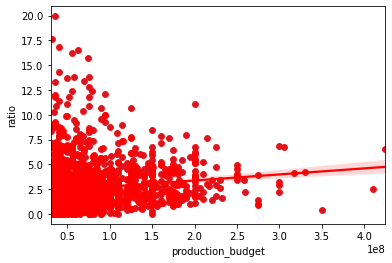

In [ ]:
sns.scatterplot(x=pb['production_budget'], y=pb.ratio)
sns.regplot(x=pb.production_budget, y=pb.ratio)